**Création d'un label de qualité des soudures basé sur une analyse en composantes principales (PCA) des propriétés mécaniques.**

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [55]:
# Charger le dataset nettoyé
dataset1_clean = pd.read_csv("../data/cleaned/dataset1_clean.csv")

In [56]:
# verifier que le dataset1_clean ne contient pas trop de valeurs manquantes dans les colonnes des propriétés mécaniques
print("Valeurs manquantes dans les colonnes des propriétés mécaniques:")
print(dataset1_clean[['Yield_strength', 'UTS', 'Elongation', 'Reduction_area']].isna().sum())

Valeurs manquantes dans les colonnes des propriétés mécaniques:
Yield_strength    872
UTS               914
Elongation        952
Reduction_area    947
dtype: int64


On fait la PCA 2D des propriétés mécaniques : Yield_strength, UTS, Elongation, Reduction_area

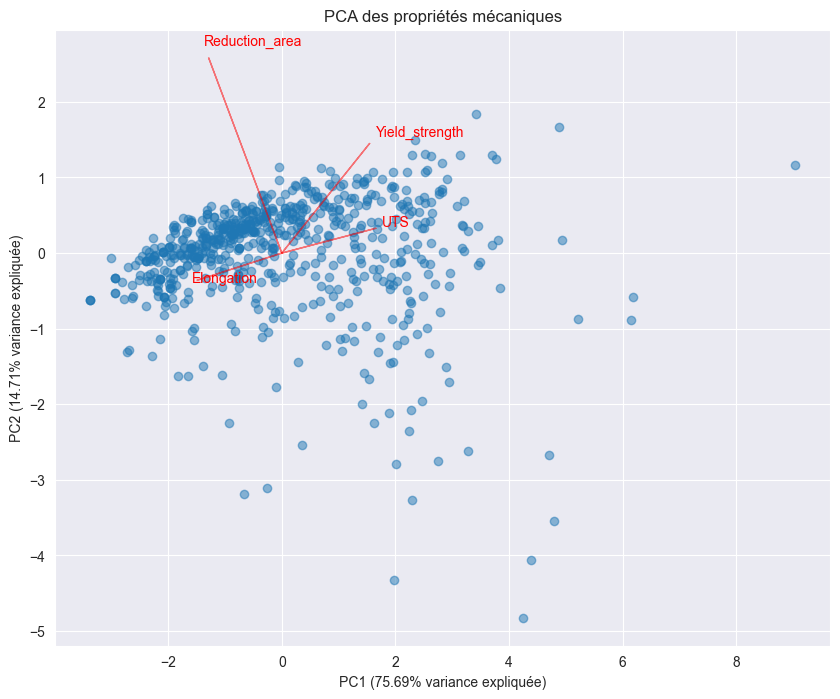

In [57]:
# Sélectionner les colonnes liées aux propriétés mécaniques
quality_cols = [
    'Yield_strength',    # Limite d'élasticité
    'UTS',              # Résistance à la traction
    'Elongation',       # Allongement
    'Reduction_area'    # Réduction de section
]

# drop les colonnes avec des valeurs manquantes
dataset1_clean = dataset1_clean.dropna(subset=quality_cols)

# Préparer les données
X = dataset1_clean[quality_cols].copy()

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer la PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualiser les résultats
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA des propriétés mécaniques')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance expliquée)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance expliquée)')

# Ajouter les vecteurs de contribution
for i, (comp1, comp2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, comp1*3, comp2*3, color='r', alpha=0.5)
    plt.text(comp1*3.2, comp2*3.2, quality_cols[i], color='r')

plt.grid(True)
plt.show()

On observe que PC1 explique la plus grande partie de la variance. On peut chercher à savoir quelles features contribuent le plus à PC1 et PC2. 

In [58]:
# Calculer les contributions absolues à PC1
pc1_contributions = pd.DataFrame({
    'Feature': quality_cols,
    'Loading': pca.components_[0],  # Composantes de PC1
    'Loading_abs': abs(pca.components_[0])  # Valeurs absolues
})

# Trier par contribution absolue
pc1_contributions = pc1_contributions.sort_values('Loading_abs', ascending=False)

# Calculer les pourcentages de contribution
total_loading = pc1_contributions['Loading_abs'].sum()
pc1_contributions['Contribution_pct'] = (pc1_contributions['Loading_abs'] / total_loading * 100)

print("Contributions à PC1:")
print(pc1_contributions[['Feature', 'Contribution_pct']].round(2))

Contributions à PC1:
          Feature  Contribution_pct
1             UTS             27.70
0  Yield_strength             25.85
2      Elongation             24.92
3  Reduction_area             21.53


On remarque que UTS et Yield_strength contribuent le plus à PC1, suivis de près par Elongation.


On cherche maintenant à trouver un label gage de qualité des soudures. 
Observons les coordonnées des vecteurs pour chaque feature.

In [59]:
# Afficher les coordonnées des vecteurs (composantes principales)
loadings = pd.DataFrame(
    pca.components_.T,  #pour avoir les features en lignes
    index=quality_cols,
    columns=['PC1', 'PC2']
)
print("Coordonnées des vecteurs:")
print(loadings.round(3))

Coordonnées des vecteurs:
                  PC1    PC2
Yield_strength  0.515  0.483
UTS             0.552  0.109
Elongation     -0.496 -0.120
Reduction_area -0.429  0.860


Cela signifie que PC1 oppose :  
À droite : résistance mécanique (UTS, Yield_strength)
À gauche : ductilité (Elongation, Reduction_area)

D'après l'analyse des coordonnées sur PC1, voici la nouvelle approche pour un label de qualité plus pertinent :  

L'opposition sur PC1 révèle un compromis entre :  
- Résistance (UTS, Yield_strength)
- Ductilité (Elongation, Reduction_area)
- 
Une soudure de qualité devrait avoir un bon équilibre entre ces propriétés.

Logique du label :
quality_high >= 2 : Une soudure est considérée de haute qualité si elle excelle dans au moins 2 propriétés mécaniques (au-dessus de la moyenne après standardisation).

In [60]:
# Compter combien de propriétés sont au-dessus de la moyenne pour chaque soudure
quality_high = (X_scaled > 0).sum(axis=1)

# Label 1 si au moins 2 propriétés sont bonnes (au-dessus de la moyenne)
quality_label = np.where(quality_high >= 2, 1, 0)

# Afficher la qualité de soudure
print("Distribution des labels de qualité :")
print(f"Soudures de moins bonne qualité (label 0): {int(counts[0])} soudures")
print(f"Soudures de bonne qualité (label 1): {int(counts[1])} soudures")
print(f"Total: {int(counts.sum())} soudures")

Distribution des labels de qualité :
Soudures de moins bonne qualité (label 0): 96 soudures
Soudures de bonne qualité (label 1): 554 soudures
Total: 650 soudures


On ajoute maintenant ce label au dataset1_clean.

In [61]:
dataset1_clean['Quality_label'] = quality_label

print("\nDistribution des labels de qualité dans le dataset :")
print(dataset1_clean['Quality_label'].value_counts())
print(f"\nTotal: {len(dataset1_clean)} soudures")


Distribution des labels de qualité dans le dataset :
Quality_label
1    554
0     96
Name: count, dtype: int64

Total: 650 soudures


In [62]:
# Sauvegarder le dataset avec le nouveau label
#dataset1_clean.to_csv("../data/cleaned/dataset1_clean_with_quality.csv", index=False)